In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
plt.style.available
plt.style.use('ggplot')

# $\gamma$/$\phi$ Formulation
* Model:
  
    * Excess Gibbs Energy: $\frac{G^E}{RT}=(A_{21}x_1+A_{12}x_2-Cx_1x_2)x_1x_2$
      
    * Binary coefficients:
      
        * $ln\gamma_1=x^2_2[A_{12}+2(A_{21}-A_{12}-C)x_1+3Cx^2_1]$
          
        * $ln\gamma_1=x^2_1[A_{21}+2(A_{12}-A_{21}-C)x_2+3Cx^2_2]$
          
    * Fugacity Coefficient: - **binary mixtures**
      
        * $\phi_1=exp(\frac{B_{11}(P-P^{sat}_1)+P(y^2_2\;\delta_{12})}{RT})$
          
        * $\phi_2=exp(\frac{B_{22}(P-P^{sat}_2)+P(y^2_1\;\delta_{12})}{RT})$
          
* Critical parameters generalization approach for binary mixtures: - Koretsky (Chapter 4. Equations of State and Intermolecular Forces)
  
    * Critical temperature: $T_{cij}=\sqrt{T_{c,i}\;T_{c,j}}(1-k^{'}_{ij})$
      
    * Compressibility factor: $Z_{cij}=\frac{Z_{ci}+Z_{cj}}{2}$
        
    * Critical pressure: $P_{cij}=\frac{{Z_{cij}RT_{cij}}}{V_{cij}}$
      
    * Accentric factor: $\omega_{pc}=\frac{\omega_i+\omega_j}{2}$
      
    * Molar volume: ${\biggl(\frac{V^{1/3}_{ci}+V^{1/3}_{cj}}{3}\biggl)}^3$

In [58]:
# Metanol = 1
# Água = 2
# Appendix A Book Milo D. Koretsky
C_R = 8.314
C_w1 = 0.559
C_w2 = 0.344
C_Tc1 = 512.6 #K
C_Tc2 = 647.3 #K
C_k12 = 0
C_Vc1 = 0.000118 #m3/mol
C_Vc2 = 5.595e-5 #m3/mol
C_Pc1 = 8096000 #Pa
C_Pc2 = 22048000 #Pa
C_Zc1 = 0.222 # Lee-Kesler diagrams to correlação de Pitzer
C_Zc2 = 0.229 # Lee-Kesler diagrams to correlação de Pitzer
conversao_mmhg = 0.0075062 # convert to Pa
C_P = 3206/conversao_mmhg


In [35]:
def f_p1sat(T):
    """Give in K, retorns in Pa"""
    T = T - 273.15 # to C
    if T < 65 or T > 214:
        raise f'Outta Bounds'
    
    A1 = 7.9701
    B1 = 1521.23
    C1 = 233.97
    return f_antoine(T, A1, B1, C1)

def f_p2sat(T):
    """Give in K, retorns in Pa"""
    T = T - 273.15 # to C
    if T < 100 or T > 265:
        raise f'Outta Bounds'
        
    A2 = 8.0177
    B2 = 1715.7
    C2 = 234.268
    return f_antoine(T, A2, B2, C2)

def f_antoine(T, A, B, C):
    """Give in K, retorns in Pa"""
    return (10**(A - B/(T+C)))/conversao_mmhg

In [36]:
def f_bs(Tr): # 3.61 , 3.62 Van Ness - Virial eq (B_0, B_1)
    return 0.083 - 0.422/(Tr**1.6), 0.139 - 0.172/(Tr**4.2)

def f_b(T, P, i=1):
    R = C_R
    w1 = C_w1
    w2 = C_w2
    Tc1 = C_Tc1
    Tc2 = C_Tc2
    k12 = C_k12
    Vc1 = C_Vc1
    Vc2 = C_Vc2
    Pc1 = C_Pc1
    Pc2 = C_Pc2
    Zc1 = C_Zc1
    Zc2 = C_Zc2
    
    Tr1 = T/Tc1
    Pr1 = P/Pc1
    Tr2 = T/Tc2
    Pr2 = P/Pc2
    
    bs1 = f_bs(Tr1)
    bs2 = f_bs(Tr2)
    
    # params from pure substance type interaction: i-i ou j-j
    b1 = bs1[0] + w1*bs1[1] #11.69a
    b2 = bs2[0] + w2*bs2[1] #11.69a
    B11 = b1*R*Tc1/Pc1 #3.62
    B22 = b2*R*Tc2/Pc2 #3.62
    
    # general approach critical properties fro binary mixtures - EQ. 10.70, 10.71, 10.72, 10.73, 10.74 do Van Ness
    w12 = (w1 + w2)/2 # 10.70
    Tc12 = ((Tc1*Tc2)**(1/2))*(1-k12) # 10.71
    Vc12 = ((Vc1**(1/3) + Vc2**(1/3))/2)**3  # 10.74
    Zc12 = (Zc1 + Zc2)/2  # 10.73
    Pc12 = (Zc12*R*Tc12)/Vc12 # 10.72
    
    Tr12 = T/Tc12
    Tr21 = Tr12
    
    bs12 = f_bs(Tr12)
    bs21 = f_bs(Tr12)
    b12 = bs12[0] + w12*bs12[1] # Pitzer correlation
    b21 = bs21[0] + w12*bs21[1] # Pitzer correlation
    
    if i ==1:
        Bjj = B11
        B12 = (b12*R*Tc12)/Pc12 #11.69b
    elif i ==2:
        Bjj = B22
        B21 = (b21*R*Tc12)/Pc12 #11.69b
        B12 = B21
    
    delta = 2*B12 - B11 - B22
    return Bjj, delta

def f_atv(xi, yi, phi, P, pisat): # 14.9 - returns fugacity coeff. (EQ. 13.65- VAN NESS)
    return (yi*phi*P)/(pisat*xi)

In [37]:
def f_phi(T, P, R, psat, y, delta, b): #14.7 a,b
    return np.exp((b*(P-psat) + P*(y**2)*delta)/(R*T))

def f_phi1(T, P, y1): #14.7
    B22, delta12 = f_b(T, P, i=1)
    R = C_R
    p1sat = f_p1sat(T)
    return f_phi(T, P, R, p1sat, y1, delta12, B22) 
    
def f_phi2(T, P, y2): #14.7
    B11, delta21 = f_b(T, P, i=2)
    R = C_R
    p2sat = f_p2sat(T)
    return f_phi(T, P, R, p2sat, y2, delta21, B11)

def f_phisat(T):
    R = C_R
    w1 = C_w1
    Tc1 = C_Tc1
    Pc1 = C_Pc1
    P = C_P
    pisat = f_p1sat(T)
    Tr1 = T/Tc1
    
    bs1 = f_bs(Tr1)
    
    b1 = bs1[0] + w1*bs1[1] #11.69a
    B11 = b1*R*Tc1/Pc1 #3.62
    
    return np.exp(B11*pisat/(R*T))

# Experimental data

In [38]:
T_exp = np.array([146.0, 135.0, 134.2, 123.5, 119.5, 118.8, 118.3, 115.1, 112.3, 109.4, 108.2, 107.0])
x1_exp = np.array([0, 0.066, 0.074, 0.23, 0.33, 0.345, 0.36, 0.513, 0.668, 0.85, 0.931, 1])
x2_exp = 1 - x1_exp
y1_exp = np.array([0, 0.238, 0.27, 0.575, 0.658, 0.667, 0.678, 0.76, 0.843, 0.928, 0.964, 1])
y2_exp = 1 - y1_exp

In [39]:
atv1_exp = []
atv2_exp = []
for i, _ in enumerate(T_exp):
    phi1 = f_phi1(T_exp[i] + 273.15, C_P, y1_exp[i])
    phi2 = f_phi2(T_exp[i] + 273.15, C_P, 1 - y1_exp[i])
    p1sat = f_p1sat(T_exp[i] + 273.15)
    p2sat = f_p2sat(T_exp[i] + 273.15)
    
    atv1 = f_atv(x1_exp[i], y1_exp[i], phi1, C_P, p1sat)
    atv2 = f_atv(1 - x1_exp[i], 1 - y1_exp[i], phi2, C_P, p2sat)
    atv1_exp.append(atv1)
    atv2_exp.append(atv2)

C:\Users\gabri\AppData\Local\Temp\ipykernel_9632\4150527816.py:59: RuntimeWarning: invalid value encountered in scalar divide
  return (yi*phi*P)/(pisat*xi)


# NRTL model: A12 and A21, fixed $\alpha = 0.2$

In [40]:
def model_atv1(xdata, A12, A21):
    """
    Give [T(K), x1] and params *popt
    Returns activity using NRTL
    """
    R = C_R
    T = xdata[0]
    x1 = xdata[1]
    x2 = 1 - x1
    alfa = 0.2 #Tese
    tau12 = A12/(R*T)
    tau21 = A21/(R*T)
    G12 = np.exp(-alfa*tau12)
    G21 = np.exp(-alfa*tau21)
    
    ln_1 = (x2**2)*(((tau21 * G21**2) / (x1 + x2 * G21)**2) + ((tau12 * G12) / (x2 + x1 * G12)**2))
    return np.exp(ln_1)  

def model_atv2(xdata, A12, A21):
    """
    Give [T(K), x1] and params *popt
    Returns activity using NRTL
    """
    R = C_R
    T = xdata[0]
    x1 = xdata[1]
    x2 = 1 - x1
    alfa = 0.2 #Tese
    tau12 = A12/(R*T)
    tau21 = A21/(R*T)
    G12 = np.exp(-alfa*tau12)
    G21 = np.exp(-alfa*tau21)
    
    ln_2 = (x1**2)*(((tau21 * G21) / (x1 + x2 * G21)**2) + ((tau12 * G12**2) / (x2 + x1 * G12)**2))
    return np.exp(ln_2)

## Arrys for curve fit

In [41]:
xdata = np.array([T_exp + 273.15, x1_exp])[:, 1:] # zero handling data
ydata1 = np.array(atv1_exp)[1:]
ydata2 = np.array(atv2_exp)[:-1]

In [42]:
popt1, pcov1 = curve_fit(model_atv1, xdata, ydata1)
popt2, pcov2 = curve_fit(model_atv2, xdata, ydata2)

# Params adjustment:  $\frac {\gamma_1 + \gamma_2}{2}$

In [43]:
popt1

array([3093.53161025, -385.24583117])

In [44]:
popt2

array([1888.52823691, -512.32372486])

In [45]:
popt = (popt1 + popt2)/2
A12, A21 = popt

In [46]:
A12

2491.0299235795846

In [47]:
A21

-448.7847780150873

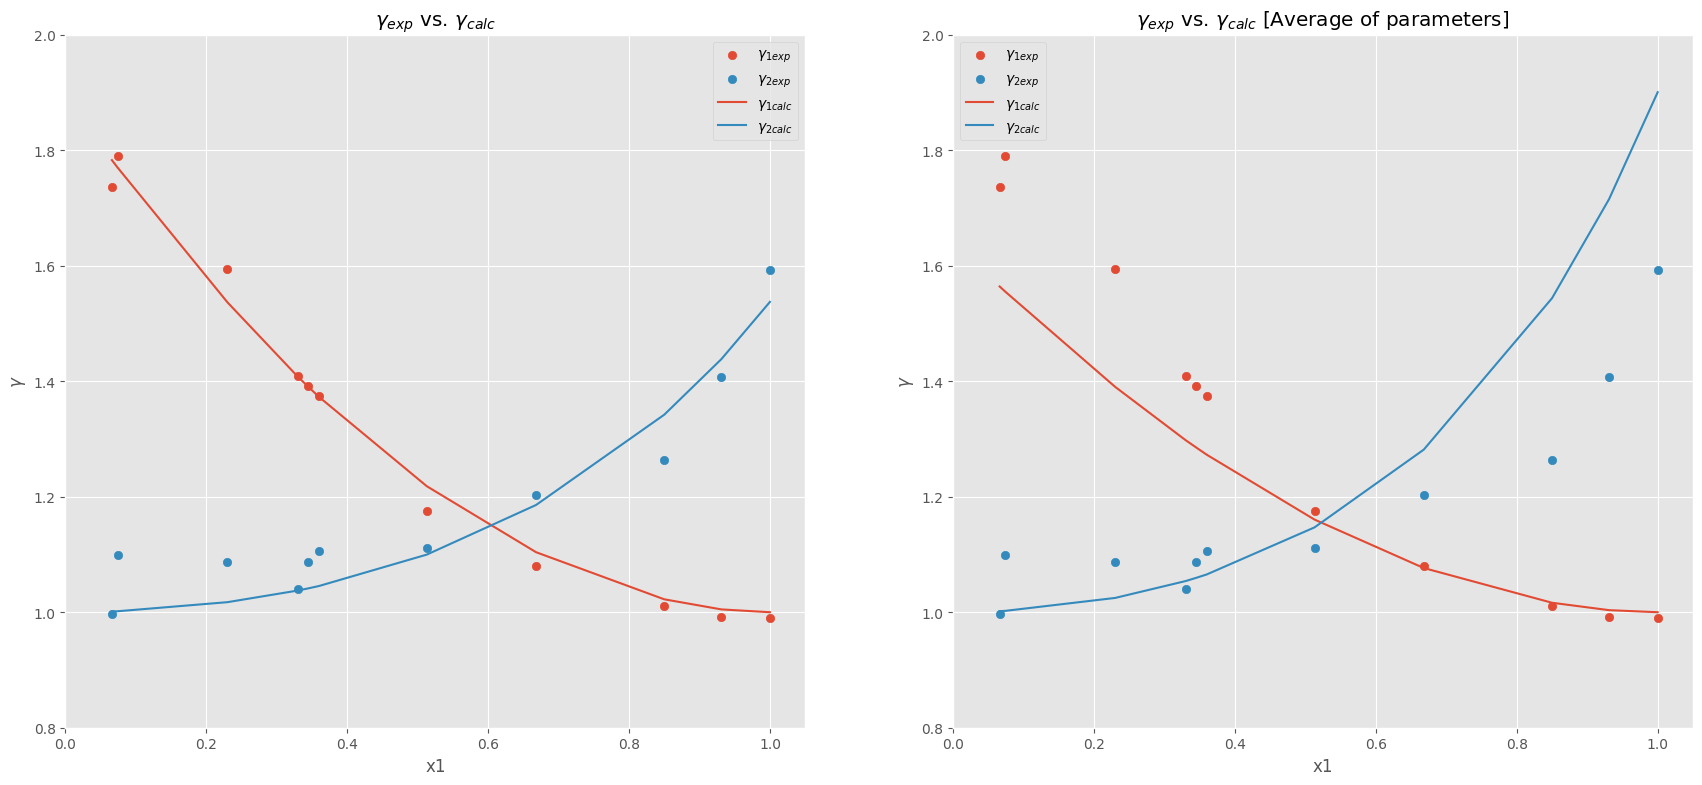

In [48]:
plt.figure(figsize=(21,9))

plt.subplot(1,2,1)
plt.scatter(xdata[1], ydata1, label='$\gamma_{1 exp}$')
plt.scatter(xdata[1], ydata2, label='$\gamma_{2 exp}$')
plt.plot(xdata[1], model_atv1(xdata, *popt1), label='$\gamma_{1 calc}$')
plt.plot(xdata[1], model_atv2(xdata, *popt2), label='$\gamma_{2 calc}$')
plt.title('$\gamma_{exp}$ vs. $\gamma_{calc}$')
plt.xlabel('x1')
plt.ylabel('$\gamma$')
plt.xlim(0, 1.05)
plt.ylim(0.8, 2)

plt.legend()

plt.subplot(1,2,2)
plt.scatter(xdata[1], ydata1, label='$\gamma_{1 exp}$')
plt.scatter(xdata[1], ydata2, label='$\gamma_{2 exp}$')
plt.plot(xdata[1], model_atv1(xdata, *popt), label='$\gamma_{1 calc}$')
plt.plot(xdata[1], model_atv2(xdata, *popt), label='$\gamma_{2 calc}$')
plt.title('$\gamma_{exp}$ vs. $\gamma_{calc}$ [Average of parameters]')
plt.xlabel('x1')
plt.ylabel('$\gamma$')
plt.xlim(0, 1.05)
plt.ylim(0.8, 2)


plt.legend()
plt.show()

## Bubble T

In [49]:
def f_Tisat(P, A, B, C): # 14.12
    """Give pressure at mmHg
    Returns °C"""
    return - C + B / (A - np.log10(P))

def f_T1sat(P=C_P):
    """Give pressure in Pa returns in K"""
    P = P*conversao_mmhg
    A1 = 7.9701
    B1 = 1521.23
    C1 = 233.97
    return 273.15 + f_Tisat(P, A1, B1, C1)

def f_T2sat(P=C_P):
    """Give pressure in Pa returns in K"""
    P = P*conversao_mmhg
    A2 = 8.0177
    B2 = 1715.7
    C2 = 234.268
    return 273.15 + f_Tisat(P, A2, B2, C2)

def f_y(x, atv, psat, phi, P=C_P):
    return (x*atv*psat) / (phi*P)


# Bubble T iteration

In [50]:
axis_x = np.linspace(0, 1, 100)
erro = 1e-6
T_calc = []
y1_calc = []
y2_calc = []
atv1_calc = []
atv2_calc = []
phi1_calc = []
phi2_calc = []

for x1 in axis_x:
    x2 = 1 - x1
    phi1 = 1
    phi2 = 1
    T1sat = f_T1sat()
    T2sat = f_T2sat()
    T = x1*T1sat + x2*T2sat
    p1sat = f_p1sat(T)
    p2sat = f_p2sat(T)
    atv1 = model_atv1([T, x1], *popt)
    atv2 = model_atv2([T, x1], *popt)
    i = 0
    while True and i < 1000:
        i+=1
        
        T0 = T
        p1sat = f_p1sat(T0)
        p2sat = f_p2sat(T0)
        y1 = f_y(x1, atv1, p1sat, phi1, P=C_P)
        y2 = f_y(x2, atv2, p2sat, phi2, P=C_P)   
        phi1 = f_phi1(T0, C_P, y1)
        phi2 = f_phi2(T0, C_P, y2)
        atv1 = model_atv1([T0, x1], *popt)
        atv2 = model_atv2([T0, x1], *popt)
        if abs(y1 + y2 -1) > erro or abs((T-T0)/T) > erro:
            if y1 + y2 > 1:
                T = T0 - T0*abs(y1 + y2 -1)/100
            else:
                T = T0 + T0*abs(y1 + y2 -1)/100
        else:
            break
    T_calc.append(T)
    y1_calc.append(y1)
    y2_calc.append(y2)
    atv1_calc.append(atv1)
    atv2_calc.append(atv2)
    phi1_calc.append(phi1)
    phi2_calc.append(phi2)


# Plot results

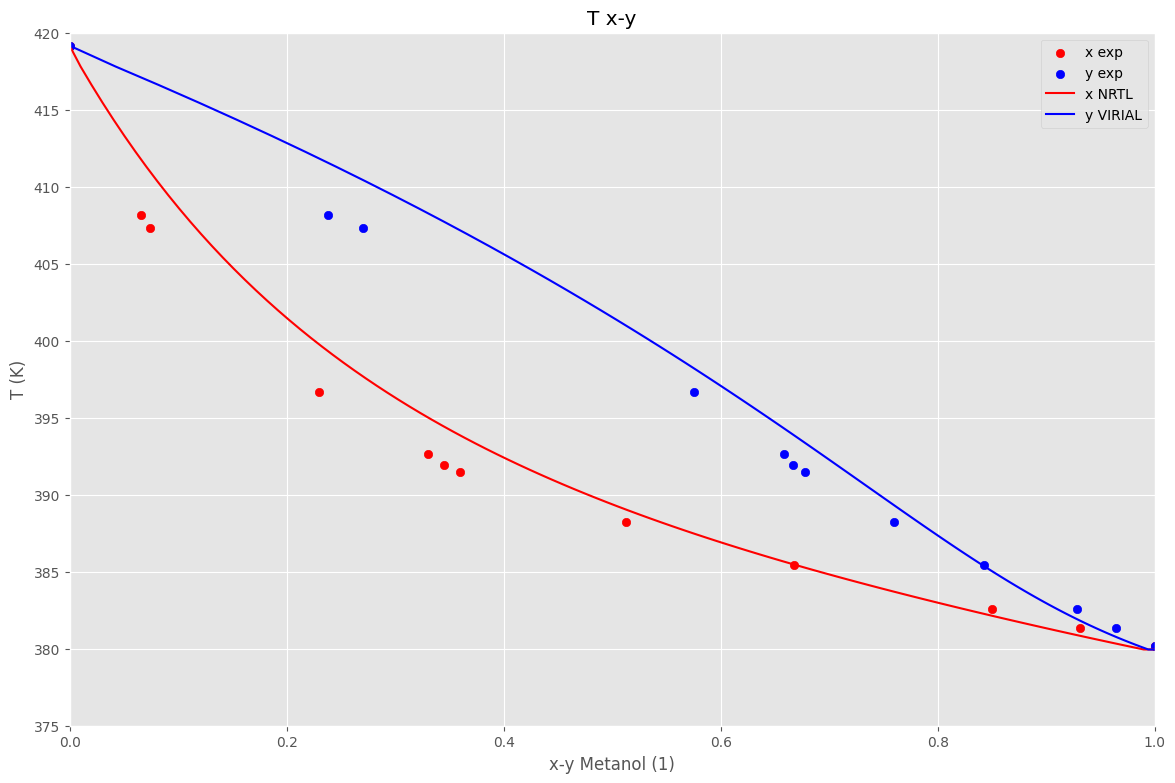

In [51]:
plt.figure(figsize=(14,9))
plt.scatter(x1_exp, T_exp + 273.15, color='red', marker='o', label='x exp')
plt.scatter(y1_exp, T_exp + 273.15, color='blue', marker='o', label='y exp')
plt.plot(axis_x, T_calc, color='red', label='x NRTL')
plt.plot(y1_calc, T_calc, color='blue', label='y VIRIAL')
plt.title('T x-y')
plt.xlabel('x-y Metanol (1)')
plt.ylabel('T (K)')
plt.legend()
plt.xlim(0, 1)
plt.ylim(375, 420)
plt.show()

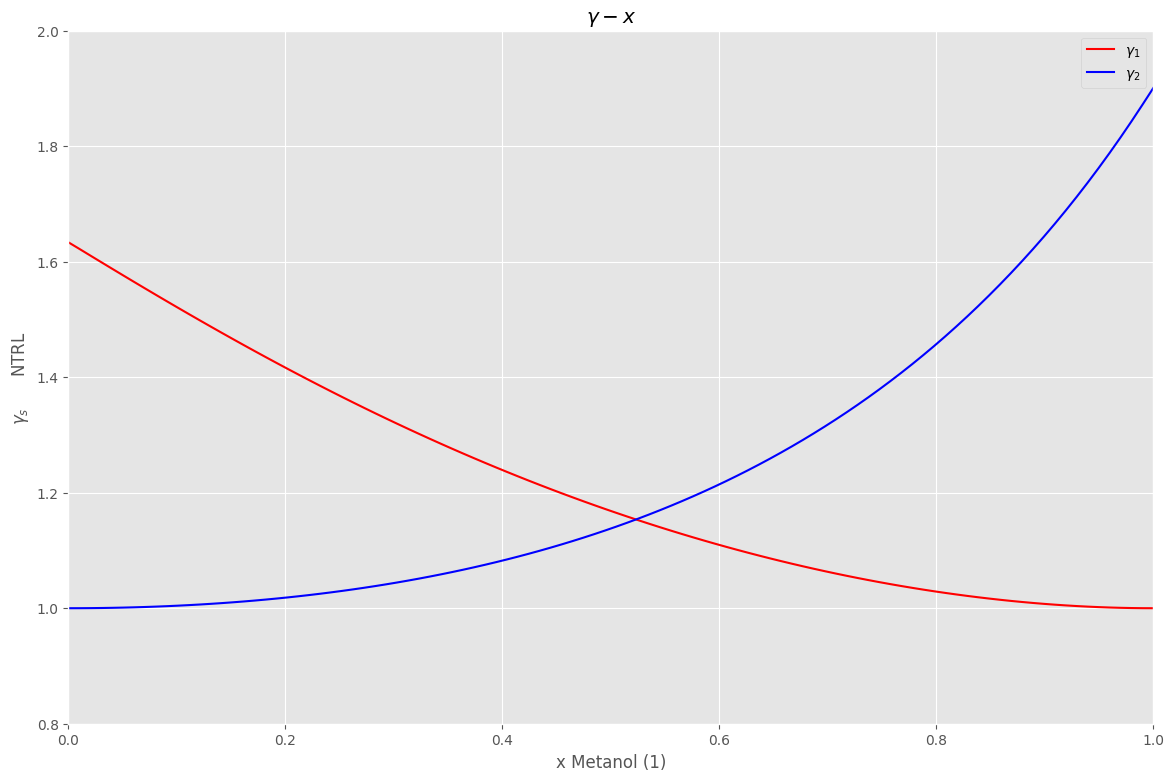

In [52]:
plt.figure(figsize=(14,9))
plt.plot(axis_x, atv1_calc, color='red', label='$\gamma_1$')
plt.plot(axis_x, atv2_calc, color='blue', label='$\gamma_2$')
plt.title('$\gamma - x$')
plt.xlabel('x Metanol (1)')
plt.ylabel('$\gamma_s$\tNTRL')
plt.legend()
plt.xlim(0, 1)
plt.ylim(0.8, 2)
plt.show()

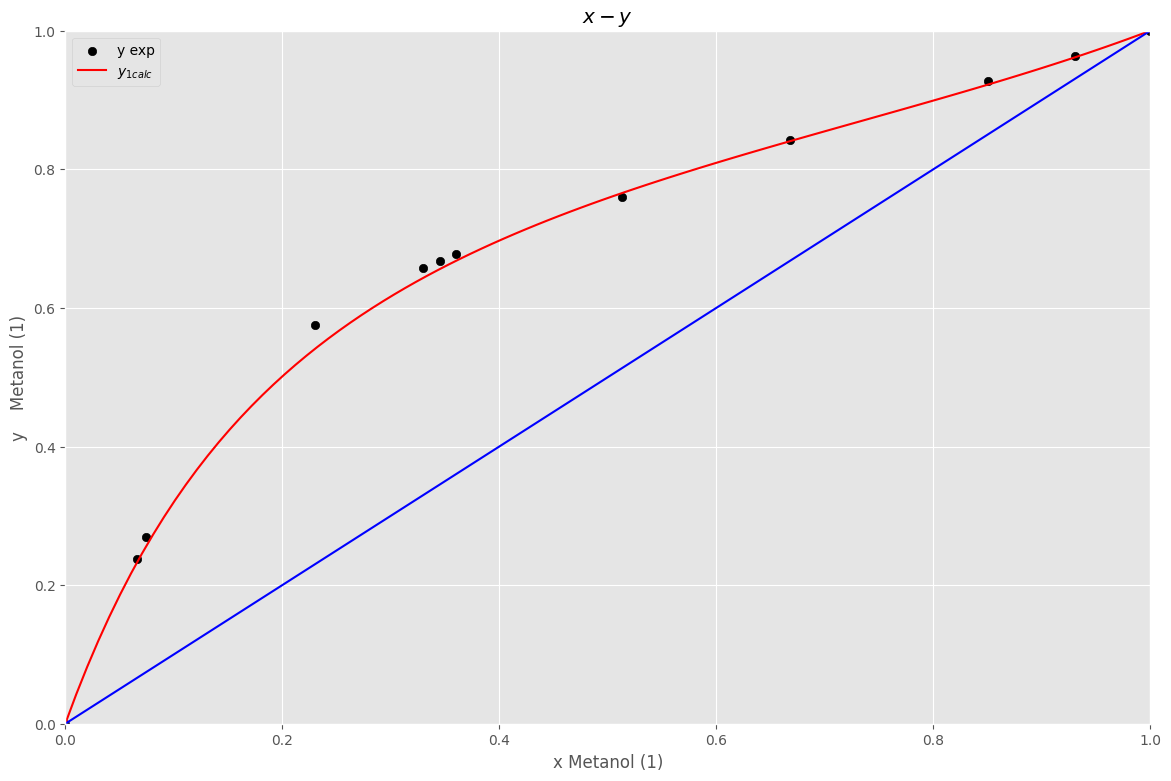

In [53]:
plt.figure(figsize=(14,9))
plt.scatter(x1_exp, y1_exp, color='black', marker='o', label='y exp')
plt.plot(axis_x, y1_calc, color='red', label='$y_{1 calc}$')
plt.plot(axis_x, axis_x, color='blue')
plt.title('$x - y$')
plt.xlabel('x Metanol (1)')
plt.ylabel('y    Metanol (1)')
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [54]:
print('T\tT calc\tx1 exp\ty1 exp\ty1 calc\ty2 exp\ty2 calc\tphi1\tphi2\t\tgamma1\tg1_exp\tgamma2\tg2_exp')

for i, _ in enumerate(T_exp):
    print(f'{T_exp[i] :>6.5}\t{T_calc[i] - 273.15:>6.5}\t{x1_exp[i]:>5.5}\t{y1_exp[i]:>5.5}\t', end='')
    print(f'{y1_calc[i]:>5.5}\t{y2_exp[i]:>5.5}\t{str(y2_calc[i])[:6]}\t', end='')
    print(f'{phi1_calc[i]:>5.5}\t{phi2_calc[i]:>7.5}\t{atv1_calc[i]:>5.5}\t', end='')
    print(f'{atv1_exp[i]:>5.5}\t{atv2_calc[i]:>5.5}\t{atv2_exp[i]:>5.5}')

T	T calc	x1 exp	y1 exp	y1 calc	y2 exp	y2 calc	phi1	phi2		gamma1	g1_exp	gamma2	g2_exp
 146.0	146.01	  0.0	  0.0	  0.0	  1.0	1.0000	1.0818	0.99708	1.6336	  nan	  1.0	0.99726
 135.0	144.65	0.066	0.238	0.042455	0.762	0.9575	1.0786	 0.9961	1.6222	1.7365	  1.0	1.0994
 134.2	143.46	0.074	 0.27	0.082085	 0.73	0.9179	1.0758	0.99526	1.6107	1.7906	1.0002	1.0867
 123.5	142.31	 0.23	0.575	0.11913	0.425	0.8808	1.0731	0.99444	1.5992	1.5947	1.0004	1.0404
 119.5	141.21	 0.33	0.658	0.15382	0.342	0.8461	1.0706	0.99365	1.5877	1.4094	1.0007	1.0868
 118.8	140.15	0.345	0.667	0.18634	0.333	0.8136	1.0681	0.99288	1.5763	1.3917	1.0011	1.106
 118.3	139.13	 0.36	0.678	0.21687	0.322	0.7831	1.0658	0.99215	1.565	1.3736	1.0016	1.1116
 115.1	138.15	0.513	 0.76	0.24558	 0.24	0.7544	1.0635	0.99144	1.5537	1.1758	1.0021	1.2036
 112.3	137.21	0.668	0.843	0.27261	0.157	0.7273	1.0614	0.99075	1.5425	1.0799	1.0028	1.2628
 109.4	 136.3	 0.85	0.928	0.29809	0.072	0.7019	1.0593	0.99009	1.5313	1.0114	1.0036	1.408
 108.2	135.42	0.931	

In [55]:
quad_erro = np.sum((y1_exp - np.asarray(y1_calc[:len(y1_exp)]))**2)

In [56]:
print(popt, popt1, popt2)

[2491.02992358 -448.78477802] [3093.53161025 -385.24583117] [1888.52823691 -512.32372486]


In [57]:
print(f'Sum of Squared errors on y: {quad_erro:.4}')

Sum of Squared errors on y: 2.807
